# Social Interaction: Mice Model and Ethogram Built

Create a model for mice using circles and ellipses. 

Body and head are ellipsoidal models based on tracking positions, and tail is a circle model. 

Model for body takes into account neck, center of mass and tail positions, while model for head takes into account neck, nose and ears positions. 

Once the model is built parameters from interaction are extracted. Most parameters are distance based, so we need to compute the distance between pairs of ellipse (or ellipse circle). Distance between elipses can computed two ways: -random sample points inside the ellipse and compute the minimum distance between all of those pairs, or sample fixed points (at certain angles) in the perimeters of the ellipse and compute distance between those fixed points.

**Distance parameters between ellipses and circles perimenters:** 

- body1-body2 (b1b2), 
- body1-head2 (b1h2), 
- body1-tail2 (b1t2), 
- body2-head1 (b2h1), 
- body2-tail1 (b2t1), 
- head1-head2 (h1h2) and 
- tail1-tail2 (t1t2).

Ellipsoidal models are based on a regression line that is computed for the axis direction. This direction can be use to compute the angular direction of each mouse. Then relative orientation between mice can be computed by the difference of angular orientation. 

**Distance parameters between model centers (ellipses and circles):** 

- body1-body2 (c_b1b2), 
- body1-head2 (c_b1h2), 
- body1-tail2 (c_b1t2), 
- body2-head1 (c_b2h1), 
- body2-tail1 (c_b2t1), 
- head1-head2 (c_h1h2)

**Angular parameters:** 
- body1-body2 (ab1b2), 
- body1-head2 (ab1h2), 
- body2-head1 (ab2h1), 
- head1-head2 (ah1h2).

We will use this parameters to set threshold in behaviour according to definitions in de Chaumon et al. Nature 2012. 'Computerized video analysis of social interactions in mice'.

**Ethograms parameters**

- CONTACT_LIM = 15
- ORAL_LIM = 25
- ORAL_GEN_LIM = 25
- ALIGN_LIM = 30
- SMALL_DISTANCE_LIM = 30


''' May 25th 2021'''


In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path
from collections import namedtuple
import random
from sklearn.linear_model import LinearRegression

### scale definition 
npixel = 500
size = 400
pscale = size / npixel
frate = 30

### Thresholds for ethogram building
CONTACT_LIM = 15
ORAL_LIM = 25
ORAL_GEN_LIM = 25
ALIGN_LIM = 30
SMALL_DISTANCE_LIM = 30


In [2]:
### Create a video with the model
import cv2
NTIME = 3500
def create_cockroaches_video(input_video_file, output_video_file,model1,model2):
    cap = cv2.VideoCapture(str(input_video_name))
    #cap.set(cv2.CAP_PROP_POS_FRAMES, frame_n)
    output = cv2.VideoWriter(str(output_video),cv2.VideoWriter_fourcc(*'MJPG'),30,(700,700))

    #model1 = model1_bias
    #model2 = model2_bias

    for frame_n in range(NTIME):

        r , frame = cap.read()    
        #frame = np.zeros((700,700,3),dtype = 'uint8')

        p1 = (0, model1.shape_model[frame_n].body.reg.intercept_)
        p2 = (700, 700* model1.shape_model[frame_n].body.reg.coef_ + model1.shape_model[frame_n].body.reg.intercept_)
        cv2.line(frame, p1, p2 , color = (255,255,255));
        p1 = (0, model1.shape_model[frame_n].head.reg.intercept_)
        p2 = (700, 700* model1.shape_model[frame_n].head.reg.coef_ + model1.shape_model[frame_n].head.reg.intercept_)
        cv2.line(frame, p1, p2 , color = (255,255,255));

        p1 = (0, model2.shape_model[frame_n].body.reg.intercept_)
        p2 = (700, 700* model2.shape_model[frame_n].body.reg.coef_ + model2.shape_model[frame_n].body.reg.intercept_)
        cv2.line(frame, p1, p2 , color = (0,0,255));
        p1 = (0, model2.shape_model[frame_n].head.reg.intercept_)
        p2 = (700, 700* model2.shape_model[frame_n].head.reg.coef_ + model2.shape_model[frame_n].head.reg.intercept_)
        cv2.line(frame, p1, p2 , color = (0,0,255));


        center1 = model1.shape_model[frame_n].body.center.astype(int)
        center2 = model2.shape_model[frame_n].body.center.astype(int)

        #print(tuple(center1))
        #print((model1.body[frame_n].axis1.astype(int),model1.body[frame_n].axis2))

        cv2.circle(frame, tuple(center1), 10, color = (255,0,0), thickness = 1)
        cv2.ellipse(frame, tuple(center1),(model1.shape_model[frame_n].body.axis1.astype(int),
                                           model1.shape_model[frame_n].body.axis2) , math.degrees(model1.shape_model[frame_n].body.angle),
                    0, 360, color = (0,0,255), thickness = 5);

        cv2.circle(frame, tuple(center2), 10, color = (255,0,0), thickness = 1)
        cv2.ellipse(frame, tuple(center2),(model2.shape_model[frame_n].body.axis1.astype(int),model2.shape_model[frame_n].body.axis2) ,
                    math.degrees(model2.shape_model[frame_n].body.angle)  , 0, 360, color = (0,255,0), thickness = 5);


        center1 = model1.shape_model[frame_n].head.center.astype(int)
        center2 = model2.shape_model[frame_n].head.center.astype(int)

        #print(tuple(center1))
        #print((model1.body[frame_n].axis1.astype(int),model1.body[frame_n].axis2))

        cv2.circle(frame, tuple(center1), 10, color = (255,0,0), thickness = 1)
        cv2.ellipse(frame, tuple(center1),(model1.shape_model[frame_n].head.axis1.astype(int),model1.shape_model[frame_n].head.axis2) , 
                    math.degrees(model1.shape_model[frame_n].head.angle)  , 0, 360, color = (0,0,255), thickness = 5);

        cv2.circle(frame, tuple(center2), 10, color = (255,0,0), thickness = 1)
        cv2.ellipse(frame, tuple(center2),(model2.shape_model[frame_n].head.axis1.astype(int),model2.shape_model[frame_n].head.axis2) , 
                    math.degrees(model2.shape_model[frame_n].head.angle)  , 0, 360, color = (0,255,0), thickness = 5);

        center1 = model1.shape_model[frame_n].tail.center.astype(int)
        center2 = model2.shape_model[frame_n].tail.center.astype(int)

        radius1 = model1.shape_model[frame_n].tail.radius
        radius2 = model2.shape_model[frame_n].tail.radius

        cv2.circle(frame, tuple(center1), radius1, color = (0,0,255), thickness = 5)
        cv2.circle(frame, tuple(center2), radius2, color = (0,255,0), thickness = 5)

        output.write(frame)
    
    return
    

In [3]:
def distance(point1,point2):
    '''
    Compute euclidian distance between 2 2D points
    input -> point1: 2D numpy array 
             point2: 2D numpy array
             
    output -> distance : float
              distance between point1 and point2
    '''
    
    xdiff = point1[0] - point2[0]
    ydiff = point1[1] - point2[1]
    dist = np.sqrt(xdiff*xdiff + ydiff*ydiff)
    return dist

def direction(point1,point2):
    '''
    Compute directiona vector 2 2D points
    input -> point1: 2D numpy array 
             point2: 2D numpy array
             
    output -> direction : numpy array
              direction that unites point1 and point2
    '''
    x_diff = point1[0] - point2[0]
    y_diff = point1[1] - point2[1]
    direction = np.array([x_diff , y_diff])
    return direction

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [4]:
def generate_theta(a, b):
    '''
    Generate a random uniformly distributed angle in an ellipse of axis lenght a and b
    input -> a: float, long ellipse axis
             b: float, short ellipse axis
             
    output -> theta: float, angle in radians
    '''
    u = random.random() / 4.0
    theta = np.arctan(b/a * np.tan(2*np.pi*u))
    v = random.random()
    if v < 0.25:
        return theta
    elif v < 0.5:
        return np.pi - theta
    elif v < 0.75:
        return np.pi + theta
    else:
        return -theta
    

def radius(a, b, theta):
    '''
    Compute distance for a point in the ellipse with axis lenght a, b
    and angle theta
    '''
    return a * b / np.sqrt((b*np.cos(theta))**2 + (a*np.sin(theta))**2)

def random_point(a, b ,center, alpha):
    '''
    Generate a random point inside an ellipse of axis lenght a, b, with center position at center
    and angle of orientation alpha (anticlockwise to the horizontal line).
    input -> a : float, mayor axis length
             b : float, minor axis length
             center: numpy 2D array, center of the ellipsoide in cartesian coordinates
             alpha :float, orientation angle in radians.
             
    output -> 2D numpy array with a random point inside the ellipse
    '''
    random_theta = generate_theta(a, b)
    max_radius = radius(a, b, random_theta)
    random_radius = max_radius * np.sqrt(random.random())

    return np.array([
        random_radius * np.cos(random_theta + alpha) + center[0],
        random_radius * np.sin(random_theta+ alpha) + center[1]
    ])

def ellipse_perimeter_points(a,b,center,alpha,npoints = 10):

    theta_values=np.arange(0,8)*math.pi/4
    ellip_x=[]
    ellip_y=[]
    for theta in theta_values:
        ellip_x.append(a*math.cos(theta + alpha) + center[0])
        ellip_y.append(b*math.sin(theta + alpha) + center[1])
    
    ellipse = [[ellip_x[i],ellip_y[i]] for i in range(len(ellip_x))]
    #print(ellipse)
    return ellipse

In [5]:
def distance_between_ellipse(ellipse1, ellipse2, npoints):
    '''
    Computes de minimal distance between two ellipses using a random sampling of both.
    Generate npoints randomly distributed inside each ellipse and computes the minimum
    distance between all set of points belonging to each ellipse. 
    
    input -> ellipse1: tuple, containing ellipse1 relevant information (axis length, center positons and angle)
             ellipse2: tuple, containing ellipse2 relevant information
             npoints : int, number of random points to sample inside each ellipse
             
    output -> min_distance: float, minimal distance between all pairs of random samples inside each ellipse.
    '''
    
    #define ellipse parameters for random generator
    a1 = ellipse1.axis1
    b1 = ellipse1.axis2
    center1 = ellipse1.center
    alpha1 = ellipse1.angle

    a2 = ellipse2.axis1
    b2 = ellipse2.axis2
    center2 = ellipse2.center
    alpha2 = ellipse2.angle

    #generate random points inside each ellipse
    ## What ever points generation to compute the distance. Poligon or random but in the perimeter
    #points1 = np.array([random_point(a1, b1, center1, alpha1) for _ in range(npoints)])
    #points2 = np.array([random_point(a2, b2, center2, alpha2) for _ in range(npoints)])
    points1 = ellipse_perimeter_points(a1, b1, center1, alpha1, npoints)
    points2 = ellipse_perimeter_points(a2, b2, center2, alpha2, npoints)
    
    distance_vector = [distance(x,y) for x in points1 for y in points2]

    argmin_distance = np.argmin(distance_vector)
    min_distance = distance_vector[argmin_distance]
    x_position = int(argmin_distance / len(points1))
    y_position = argmin_distance % len(points1)
    points_set = np.array([points1[x_position],points2[y_position]])
    
    distance_parameters = namedtuple('distance_parameters',['min_distance','points_set'])
    
    return distance_parameters(min_distance,points_set)

def distance_ellipse_circle(ellipse,circle, npoints):
    
    '''
    Computes de minimal distance between one ellipse and a circle using a random sampling of both.
    Generate npoints randomly distributed inside each geomwtrical shape and computes the minimum
    distance between all set of points belonging to each one of them. 
    
    input -> ellipse: tuple, containing ellipse relevant information (axis length, center positons and angle)
             circle: tuple, containing circle relevant information (radius and center position)
             npoints : int, number of random points to sample inside each shape
             
    output -> min_distance: float, minimal distance between all pairs of random samples inside each shape.
    '''
    #define ellipse parameters for random generator
    a1 = ellipse.axis1
    b1 = ellipse.axis2
    center1 = ellipse.center
    alpha1 = ellipse.angle

    r = circle.radius
    center2 = circle.center
    
    #generate random points inside each ellipse
    #points1 = np.array([random_point(a1, b1, center1, alpha1) for _ in range(npoints)])
    #points2 = np.array([random_point(r, r, center2, 0) for _ in range(npoints)])
    points1 = ellipse_perimeter_points(a1, b1, center1, alpha1, npoints)
    points2 = ellipse_perimeter_points(r, r, center2, 0, npoints)
    
    distance_vector = [distance(x,y) for x in points1 for y in points2]

    argmin_distance = np.argmin(distance_vector)
    min_distance = distance_vector[argmin_distance]
    x_position = int(argmin_distance / len(points1))
    y_position = argmin_distance % len(points1)
    points_set = np.array([points1[x_position],points2[y_position]])
    
    distance_parameters = namedtuple('distance_parameters',['min_distance','points_set'])
    return distance_parameters(min_distance,points_set)

def distance_between_circle(circle1, circle2):
    '''
    Distance between to circles given the positions and radius of each.
    
    input -> circle1: tuple, containing circle1 relevant information (radius and center position)
             circle2: tuple, containing circle2 relevant information (radius and center position)
             
    output -> min_distance: float, is cero if circles intersect, and minimal distance between circle borders
    if the circles do not intersect.
    '''
    #define circle1 parameters
    r1 = circle1.radius
    center1 = circle1.center

    #define circle2 parameters
    r2 = circle2.radius
    center2 = circle2.center

    center_distance = distance(center1,center2) 
    min_distance = 0
    if center_distance > (r1+r2):
        min_distance = center_distance - (r1+r2)
    
    return min_distance

def angular_distance(theta1,theta2):
    '''
    Compute the distance between two angles
    input-> theta1: float, angle1 in range -pi and pi in radians
            theta2: float, angle2 in range -pi and pi in radians
            
    output -> angle: float, difference between angle1 and angle2.
                     range -pi and pi in radians
    '''
    return np.arctan2(np.sin(theta1-theta2),np.cos(theta1-theta2))

In [6]:
def circle_model(point):
    ### in construction
    '''
    Compute the center of the circle 

    ans radius
    
    input -> point: numpy array with position
    
    output -> circle: tupple containing circle's relevant parameters
              circle based model contains center and radius. 
    '''
    center = point
    #print(center.shape)
    #if point.shape[0]>1:
    #    center = np.mean(point,axis=1)
    radius = 3
    circle = namedtuple('circle',['center','radius'])
    
    return circle(center,radius)

def ellipse_model(points_set = None , axis_length = [0,0]):
    
    '''
    Compute center and axis lenght of the elipse along the the axis that optimal fits
    neck, com and tail positions.
    input -> points : numpy array
                set of points with at least the next points information
                point1 -> Neck position
                point2 -> Center of mass position
                point3 -> tail position
    output -> ellipse: tuple with ellipse definition parameters. 
              ellipsoide based model contains center, both radious, axis lenght, angle orientation and focus.
    '''
    #compute line for principal axis of the elipsoide
    X = points_set[:,0]
    y = points_set[:,1]
    reg = LinearRegression().fit(X.reshape(-1,1), y.reshape(-1,1))

    #compute center of the elipsoude
    C_x = np.mean(points_set[:,0])
    C_y = float(reg.predict(C_x.reshape(-1,1)))
    center = np.array([C_x,C_y])
    
    # compute angle of principal axis
    bias = reg.predict(np.array([0]).reshape(-1,1))
    angle =  float(np.arctan2(center[1] - bias , center[0]))
    
    #compute axis1 and axis2 length 
    axis1 = np.linalg.norm(points_set[-1,:]-points_set[0,:])/2  #big axis is variable
    axis2 = axis_length[1] #small axis is fixed
    
    #compute ellipse focus based on axis length and angle
    gamma = np.sqrt(abs(axis1**2 - axis2**2))
    focus1_x = C_x + gamma * np.cos(angle)
    focus1_y = C_y + gamma * np.sin(angle)
    focus1 = np.array([focus1_x,focus1_y])

    focus2_x = C_x - gamma * np.cos(angle)
    focus2_y = C_y - gamma * np.sin(angle)
    focus2 = np.array([focus2_x,focus2_y])
    
    ellipse = namedtuple('elipse', ['reg', 'center', 'angle', 'axis1', 'axis2','focus1','focus2'])
    return ellipse(reg, center , angle, axis1, axis2, focus1, focus2)

def mouse_shape_model(position = None):
    
    '''
    Create a model of a mouse based on ellipses that are constructud by taking into account body positions.
    
    input -> position: numpy array, contains body parts positions. 
    Here we use the convetion for labeling: Nose, RightEar, LeftEar, Neck, CenterOfMass, Tail. 
    Body parts are assigned using that order. If the labeling changes, here the inputs
    to the model funcions need to be modify.
    
    output -> shape : tupple, that contains the model for head, body and tail of a mouse.
                      ellipsoide based model contains center, both radious, axis lenght, angle orientation and focus.
                      circle based model contains center and radius. 
    '''
    #head model
    head_parts = position[[0,3],:]
    head_model = ellipse_model(points_set = head_parts,axis_length = [0,10])
    
    #body model
    body_parts = position[[3,4,5],:]
    body_model = ellipse_model(points_set = body_parts, axis_length = [0,20])
    
    #tail model
    tail_parts = position[5,:]
    tail_model = circle_model(tail_parts)

    shape = namedtuple('mouse_model', ['head', 'body', 'tail'])
    return shape(head_model , body_model, tail_model)

def mouse_temporal_model(tracking = None):
    
    '''
    Create a mouse model with temporal evolucion. Shape contains all the static information.
    If a model of movement is required it can be added here with temporal information.
    
    input -> tracking : tracking of a single animals positions
    
    output -> mouse_mode: model of the mouse movement in time. Shape model contains ellipsoidal static
    mouse model.
    '''

    shape_model = [mouse_shape_model(position = tracking[:,i,:]) for i in range(tracking.shape[1])]
    mouse_model = namedtuple('mouse_model', ['shape_model'])

    return mouse_model(shape_model)

In [7]:
def get_model_static_parameters(shape_model1 = None, shape_model2= None):
    
    '''
    This function will receive the mouse model and compute relevant STATIC parameters over the
    mouse ellipsoidal model.
    
    input -> shape_model1 : ellipsoidal/circular model for animal 1
             shape_model2 : ellipsoidal/circular model for animal 2
             
    output -> tupple with relevant parameters
    '''
    ## define body parts with model
    body1 = shape_model1.body
    body2 = shape_model2.body
    head1 = shape_model1.head
    head2 = shape_model2.head
    tail1 = shape_model1.tail
    tail2 = shape_model2.tail
        
    ## compute distances between different model body parts
    NPOINTS = 10 # number of random samples for ellipsoide distance computation
    
    
    #same body part distance
    bodybody = distance_between_ellipse(body1, body2, npoints = NPOINTS)
    db1b2 = bodybody.min_distance
    pb1b2 = bodybody.points_set
    
    headhead = distance_between_ellipse(head1, head2, npoints = NPOINTS)
    dh1h2 = headhead.min_distance
    ph1h2 = headhead.points_set
    
    dt1t2 = distance_between_circle(tail1,tail2)
    pt1t2 = np.array([tail1.center,tail2.center])
    #crossed distances
    
    bodyhead = distance_between_ellipse(body1,head2, npoints = NPOINTS)
    db1h2 = bodyhead.min_distance
    pb1h2 = bodyhead.points_set
    
    bodytail = distance_ellipse_circle(body1,tail2,npoints = NPOINTS)
    db1t2 = bodytail.min_distance
    pb1t2 = bodytail.points_set
    
    headbody = distance_between_ellipse(body2,head1, npoints = NPOINTS)
    db2h1 = headbody.min_distance
    pb2h1 = headbody.points_set
    
    tailbody = distance_ellipse_circle(body2,tail1, npoints = NPOINTS)
    db2t1 = tailbody.min_distance
    pb2t1 = tailbody.points_set
    
    distance_points = namedtuple('distance_points',['b1b2','b1h2','b1t2','b2h1','b2t1','h1h2','t1t2'])
    
    ## distance between centers of the model
    c_h1h2 = distance(head1.center,head2.center)
    c_b1b2 = distance(body1.center,body2.center)
    c_b1t2 = distance(body1.center,tail2.center)
    c_b2t1 = distance(body2.center,tail1.center)
    c_h1t2 = distance(head1.center,tail2.center)
    c_h2t1 = distance(head2.center,tail1.center)
    
    #distance parameters tuple
    distance_parameters = namedtuple('distance_parameters', ['b1b2','b1h2','b1t2','b2h1','b2t1','h1h2','t1t2', 'c_h1h2', 'c_b1b2','c_b1t2','c_b2t1', 'c_h1t2', 'c_h2t1'])
    
    ## compute angle distances between body parts directions (using ellipses angle)
    ab1b2 = angular_distance(body1.angle,body2.angle)
    ab1h2 = angular_distance(body1.angle,head2.angle)
    ab2h1 = angular_distance(body2.angle,head1.angle)
    ah1h2 = angular_distance(head1.angle,head2.angle)
    
    #direction parameters tuple
    direction_parameters = namedtuple('direction_parameters', ['b1b2', 'b1h2', 'b2h1','h1h2'])
    
    parameters = namedtuple('parameters',['distance_parameters','distance_points','direction_parameters'])
        
    return parameters(distance_parameters(db1b2,db1h2,db1t2,db2h1,db2t1,dh1h2,dt1t2,c_h1h2,c_b1b2,c_b1t2,c_b2t1,c_h1t2,c_h2t1), 
                      distance_points(pb1b2,pb1h2,pb1t2,pb2h1,pb2t1,ph1h2,pt1t2),
                      direction_parameters(ab1b2,ab1h2,ab2h1,ah1h2))

In [8]:
def get_model_dynamic_parameters(model1 = None, model2= None, static_parameters = None):
    
    center_position1 = [model1.shape_model[frame_n].body.center for frame_n in range(len(model1.shape_model))]
    center_position2 = [model2.shape_model[frame_n].body.center for frame_n in range(len(model2.shape_model))]
    
    center_speed1  = np.diff(center_position1,axis=0)
    speed1 = [np.sqrt(center_position1[i][0]**2 + center_position1[i][1]**2) for i in range(len(center_position1))]
    center_speed1  = np.diff(center_position2,axis=0)
    speed2 = [np.sqrt(center_position2[i][0]**2 + center_position2[i][1]**2) for i in range(len(center_position2))]
    
    contact_distance = [min(static_parameters[frame_n].distance_parameters) for frame_n in range(len(static_parameters))]
    contact_distance_speed = np.diff(contact_distance)
    
    parameters = namedtuple('parameters',['HostSpeed','VisitSpeed','ContactSpeed'])
    
    return parameters(speed1,speed2,contact_distance_speed)

In [9]:
def get_tracking_parameters(tracking = None, body_parts = None):
    
    '''
    (NO MODEL BASED PARAMETERS)
    
    This function will receive the final positions of body parts directly from the scking (after estimation of nose position)
    It will have N*2 entraces, where N is the number of body parts per animal
    For starting point we will use the nose of the tracker and then refine it to another nose position
    using other information (as drive position, maybenose, accelerometer, etc).
    '''
    
    N = int(np.min(tracking.shape)/6)
    tpoints = tracking.shape[0]
    
    #separate animals tracking
    tracking1 = np.array([tracking[:,[i*3,i*3+1]] for i in range(N)])
    tracking2 = np.array([tracking[:,[i*3+N*3,i*3+1+N*3]] for i in range(N)])
    
    print(tracking1.shape)
    
    #compute center of mass taking into account all bodyparts
    cm1 =  np.mean(tracking1,axis=0)
    cm2 =  np.mean(tracking2,axis=0)
    
    #compute speed
    v1 = np.array([np.diff(cm1[:,i], prepend = 0) for i in range(2)]).T
    speed1 = np.linalg.norm(v1,axis = 0)
    v2 = np.array([np.diff(cm2[:,i], prepend = 0) for i in range(2)]).T
    speed2 = np.linalg.norm(v2,axis = 0)
    
    #compute head direction
    hd1= np.array([direction(tracking1[3,i,:],tracking1[0,i,:]) for i in range(tpoints)])
    hd2= np.array([direction(tracking2[3,i,:],tracking1[0,i,:]) for i in range(tpoints)])

    #compute body direction
    bd1= np.array([direction(tracking1[4,i,:],tracking1[3,i,:]) for i in range(tpoints)])
    bd2= np.array([direction(tracking2[4,i,:],tracking1[3,i,:]) for i in range(tpoints)])

    parameters = {'cm1' : cm1 , 'cm2': cm2, 'head_direction1': hd1 , 'head_direction2': hd2 , 
                  'speed1' : speed1, 'speed2': speed2 ,
                  'body_direction1': bd1, 'body_direction2': bd2}

    return parameters(cm1,cm2,head_direction1,head_direction2,speed1,speed2,body_direction1,body_direction2)

In [10]:
fields_static=['contact', 'oral_oral', 'oral_genital','genital_oral','side_side_same','side_side_op','small_distance', 'Hbehind', 'Vbehind']
interactionClass_static = {key: False for key in fields_static}

def static_ethogram(pf):
    interaction = interactionClass_static
    
    contact_distance = min(pf.distance_parameters)*pscale
    oral_contact = pf.distance_parameters.c_h1h2*pscale
    oral_genital1 = pf.distance_parameters.c_h1t2*pscale
    oral_genital2 = pf.distance_parameters.c_h2t1*pscale

    direction_angle = math.degrees(pf.direction_parameters.b1b2)
    head1_head2 = pf.distance_parameters.h1h2*pscale
    body1_body2 = pf.distance_parameters.b1b2*pscale

    belly1_tail2 = pf.distance_parameters.c_b1t2*pscale
    belly2_tail1 = pf.distance_parameters.c_b2t1*pscale
    
    #print(contact_distance, oral_contact, oral_genital1, oral_genital2, direction_angle)

    ## contact behaviour 1 to 6
    interaction['contact'] = contact_distance < CONTACT_LIM
    interaction['oral_oral'] = oral_contact < ORAL_LIM
    interaction['oral_genital'] = oral_genital1 < ORAL_GEN_LIM
    interaction['genital_oral'] = oral_genital2 < ORAL_GEN_LIM    
    angle_condition = 0 < direction_angle < 90 or 270 < direction_angle < 360
    distance_condition = head1_head2 < SMALL_DISTANCE_LIM and body1_body2 < SMALL_DISTANCE_LIM 
    interaction['side_side_same'] = angle_condition and distance_condition
    angle_condition = 90 < direction_angle < 270
    interaction['side_side_op'] = angle_condition and distance_condition
    
    ## small distance (relative positons behavior) from 7 to 9
    interaction['small_distance'] = contact_distance < SMALL_DISTANCE_LIM
    interaction['Hbehind'] = belly1_tail2 < belly2_tail1
    interaction['Vbehind'] = not interaction['Hbehind']
    
    ## still event 10 need to be constructed
    
    return interaction

In [11]:
fields_dyn=['HostToVisit', 'VisitToHost', 'HostAwayVisit','VisitAwayHost']#,'FollowBehaviour']
interactionClass_dyn = {key: False for key in fields_dyn}

def dynamic_ethogram(static_ethogram, dynamic_parameters):
    
    interaction = interactionClass_dyn
    
    HostSpeed = dynamic_parameters.HostSpeed
    VisitSpeed = dynamic_parameters.VisitSpeed
    ContactSpeed = dynamic_parameters.ContactSpeed
    

    ## contact behaviour 11 to 14
    relative_movement = [HostSpeed[i] > VisitSpeed[i] for i in range(len(HostSpeed))]    
    interaction['HostToVisit'] = [relative_movement[i] and ContactSpeed[i] < 0 for i in range(len(HostSpeed)-1)]
    interaction['VisitToHost'] = [not relative_movement[i] and ContactSpeed[i] < 0 for i in range(len(HostSpeed)-1)]
    interaction['HostAwayVisit'] = [relative_movement[i] and ContactSpeed[i] > 0 for i in range(len(HostSpeed)-1)]
    interaction['VisitAwayHost'] = [not relative_movement[i] and ContactSpeed[i] > 0 for i in range(len(HostSpeed)-1)]
    
    ## still event 15 need to be constructed
    
    return interaction

In [12]:
fields_trans=['HostCaptureVisit', 'VisitCaptureHost', 'HostEscapeVisit', 'VisitEscapeHost', 'HostFailedCaptureVisit', 
              'VisitFailedCaptureHost', 'HostUndecided', 
              'VisitUndecided']
interactionClass_trans = {key: False for key in fields_trans}

def transition_ethogram(static_ethogram, dynamic_ethogram):
    
    interaction = interactionClass_trans
    
    ## interactions from 16 to 19
    interaction['HostCaptureVisit'] = [static_ethogram[i]['contact'] and dynamic_ethogram['HostToVisit'][i-1] for i in range(1,len(static_ethogram))]
    interaction['VisitCaptureHost'] = [static_ethogram[i]['contact'] and dynamic_ethogram['VisitToHost'][i-1] for i in range(1,len(static_ethogram))]
    interaction['HostEscapeVisit'] = [not static_ethogram[i]['contact'] and dynamic_ethogram['HostAwayVisit'][i-1] for i in range(1,len(static_ethogram))]
    interaction['VisitEscapeHost'] = [not static_ethogram[i]['contact'] and dynamic_ethogram['VisitAwayHost'][i-1] for i in range(1,len(static_ethogram))]
   

    ## intetractions 20 to 23
    interaction['HostFailedCaptureVisit'] = [interaction['HostCaptureVisit'][i] and interaction['VisitEscapeHost'][i+1] for i in range((len(interaction['HostCaptureVisit'])))]
    interaction['VisitFailedCaptureHost'] = [interaction['VisitCaptureHost'][i] and interaction['HostEscapeVisit'][i+1] for i in range((len(interaction['HostCaptureVisit'])))]
    interaction['HostUndecided'] = [interaction['HostCaptureVisit'][i] and interaction['HostEscapeVisit'][i+1] for i in range((len(interaction['HostCaptureVisit'])))]
    interaction['VisitUndecided'] = [interaction['VisitCaptureHost'][i] and interaction['VisitEscapeHost'][i+1] for i in range((len(interaction['HostCaptureVisit'])))]

    return interaction

In [32]:
def plot_labeled_frame(input_video_file, frame_number, model1,model2,tracking1 = None,tracking2=None):
    
    cap = cv2.VideoCapture(str(input_video_file))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_n)
    r , frame = cap.read()    
    shape1 = model1.shape_model[frame_n]
    shape2 = model2.shape_model[frame_n]

    figure, axes = plt.subplots(1,2,figsize = (40,20))

    pf = get_model_static_parameters(shape_model1 = shape1, shape_model2= shape2)

    ### plot contact vector
    contact_distance = min(pf.distance_parameters)*pscale
    print('CONTACT_DISTANCE:', contact_distance)
    contact_distance_parts = np.argmin(pf.distance_parameters)
    if contact_distance_parts < 7:
        contact_distance_points = pf.distance_points[contact_distance_parts]
        x = [contact_distance_points[0,0],contact_distance_points[1,0]]
        y = [contact_distance_points[0,1],contact_distance_points[1,1]]
        axes[0].plot(x, y, color="red", linewidth=3)

    ### plot oral_contact vector
    print('ORAL-ORAL:', pf.distance_parameters.c_h1h2*pscale)
    x = [model1.shape_model[frame_n].head.center[0],model2.shape_model[frame_n].head.center[0]]
    y = [model1.shape_model[frame_n].head.center[1],model2.shape_model[frame_n].head.center[1]]
    axes[0].plot(x, y, color="green", linewidth=3)

    ### plot oral_genital vector
    print('ORAL-GENITAL:', pf.distance_parameters.c_h1t2*pscale)
    x = [model1.shape_model[frame_n].head.center[0],model2.shape_model[frame_n].tail.center[0]]
    y = [model1.shape_model[frame_n].head.center[1],model2.shape_model[frame_n].tail.center[1]]
    axes[0].plot(x, y, color="blue", linewidth=3)
    print('ORAL-GENITAL2:',distance(model1.shape_model[frame_n].head.center,model2.shape_model[frame_n].tail.center)*pscale)


    ### plot genital_oral vector
    print('GENITAL-ORAL:', pf.distance_parameters.c_h2t1*pscale)
    x = [model2.shape_model[frame_n].head.center[0],model1.shape_model[frame_n].tail.center[0]]
    y = [model2.shape_model[frame_n].head.center[1],model1.shape_model[frame_n].tail.center[1]]
    axes[0].plot(x, y, color="violet", linewidth=3)

    ### plot directions 
    p1 = [0, 700]
    p2 = [model1.shape_model[frame_n].body.reg.intercept_, 700* model1.shape_model[frame_n].body.reg.coef_ + model1.shape_model[frame_n].body.reg.intercept_]
    axes[0].plot(p1, p2, color="white", linewidth=1, linestyle = "dashed")

    p1 = [0, 700]
    p2 = [model2.shape_model[frame_n].body.reg.intercept_, 700* model2.shape_model[frame_n].body.reg.coef_ + model2.shape_model[frame_n].body.reg.intercept_]
    axes[0].plot(p1, p2, color="white", linewidth=1, linestyle = "dashed")

    axes[0].legend(['contact','oral-oral','oral-gen','gen-oral','dir1','dir2'])
    axes[0].imshow(frame)#, origin = 'lower')
    
    interactions = static_ethogram(pf).values()
    print(interactions)
    axes[1].bar(np.arange(0,len(interactions)),interactions)
    axes[1].set_xticks(np.arange(0,len(interactions)))
    axes[1].set_xticklabels(fields_static,rotation = 45);
    
    return

### Build a model and get parameters based on the tracking from DLC

In [14]:
## load tracking information
tracking_path = Path('/home/melisa/Documents/social_interaction/')
tracking_path.exists()
input_file_name = 'raw180sDLC_resnet50_ANewGenerationMay12shuffle1_320000_NO_BIAS.csv'
input_file_name_bias  = 'raw180sDLC_resnet50_ANewGenerationMay12shuffle1_320000_08BIAS.csv'

input_video_name = tracking_path / 'raw120s.mp4'
output_video = tracking_path / 'ellipse_120_maybeNose_bias.avi'

tracking_DFrame = pd.read_csv(tracking_path / input_file_name)
tracking_DFrame_bias = pd.read_csv(tracking_path / input_file_name_bias)
#tracking_DFrame

In [17]:
## get body parts from tracking fil
body_parts = [tracking_DFrame.iloc[0][i*3+1] for i in range(int(len(tracking_DFrame.iloc[0])/3))]
body_part_structure = [tracking_DFrame.iloc[1][i+1] for i in range(3)]

In [18]:
# convert tracking pandas to numpy
tracking_DFrame = tracking_DFrame.iloc[2:]
tracking_DFrame = tracking_DFrame.astype(float)
tracking_data = tracking_DFrame.to_numpy()

tracking_DFrame_bias = tracking_DFrame_bias.iloc[2:]
tracking_DFrame_bias = tracking_DFrame_bias.astype(float)
tracking_data_bias = tracking_DFrame_bias.to_numpy()

In [20]:
# get parameters from tracking directly
body_tracking = tracking_data[:,1+5*3:];
body_tracking_bias = tracking_data_bias[:,1+5*3:];
print('Body tracking shape: ' + f'{body_tracking.shape}')

Body tracking shape: (5400, 36)


In [22]:
## separate animals to build a model of mouse
NTIME = body_tracking.shape[0]
N = int(np.min(body_tracking.shape)/6)

#separate animals tracking
tracking1 = np.array([body_tracking[:,[i*3,i*3+1]] for i in range(N)])
tracking2 = np.array([body_tracking[:,[i*3+N*3,i*3+1+N*3]] for i in range(N)])

## replace nose model (here by maybe nose)
maybeNose = tracking_data[:,13:15]
tracking1[0,:,:] = maybeNose 
### TO DO: LETS CREATE A NOSE MODEL AND EXCHANGE THE NOSE TRACKING FOR THE NOSE MODEL POSITION
### BASED ON DRIVES POSITION. 

In [23]:
### TO DO: ADD LIKELIHOOD FOR THE SELECTION!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
###create a model
model1 = mouse_temporal_model(tracking = tracking1)
model2 = mouse_temporal_model(tracking = tracking2) 

In [36]:
## same with bias
N = int(np.min(body_tracking_bias.shape)/6)
#separate animals tracking
tracking1 = np.array([body_tracking_bias[:,[i*3,i*3+1]] for i in range(N)])
tracking2 = np.array([body_tracking_bias[:,[i*3+N*3,i*3+1+N*3]] for i in range(N)])

maybeNose = tracking_data_bias[:,13:15]
tracking1[0,:,:] = maybeNose 

###create a model
model1_bias = mouse_temporal_model(tracking = tracking1)
model2_bias = mouse_temporal_model(tracking = tracking2) 

## Create video and do frame plotting

CONTACT_DISTANCE: 216.08522728185153
ORAL-ORAL: 279.7508947872647
ORAL-GENITAL: 304.2859478686521
ORAL-GENITAL2: 304.2859478686521
GENITAL-ORAL: 237.70376607651383
dict_values([False, False, False, False, False, False, False, False, True])


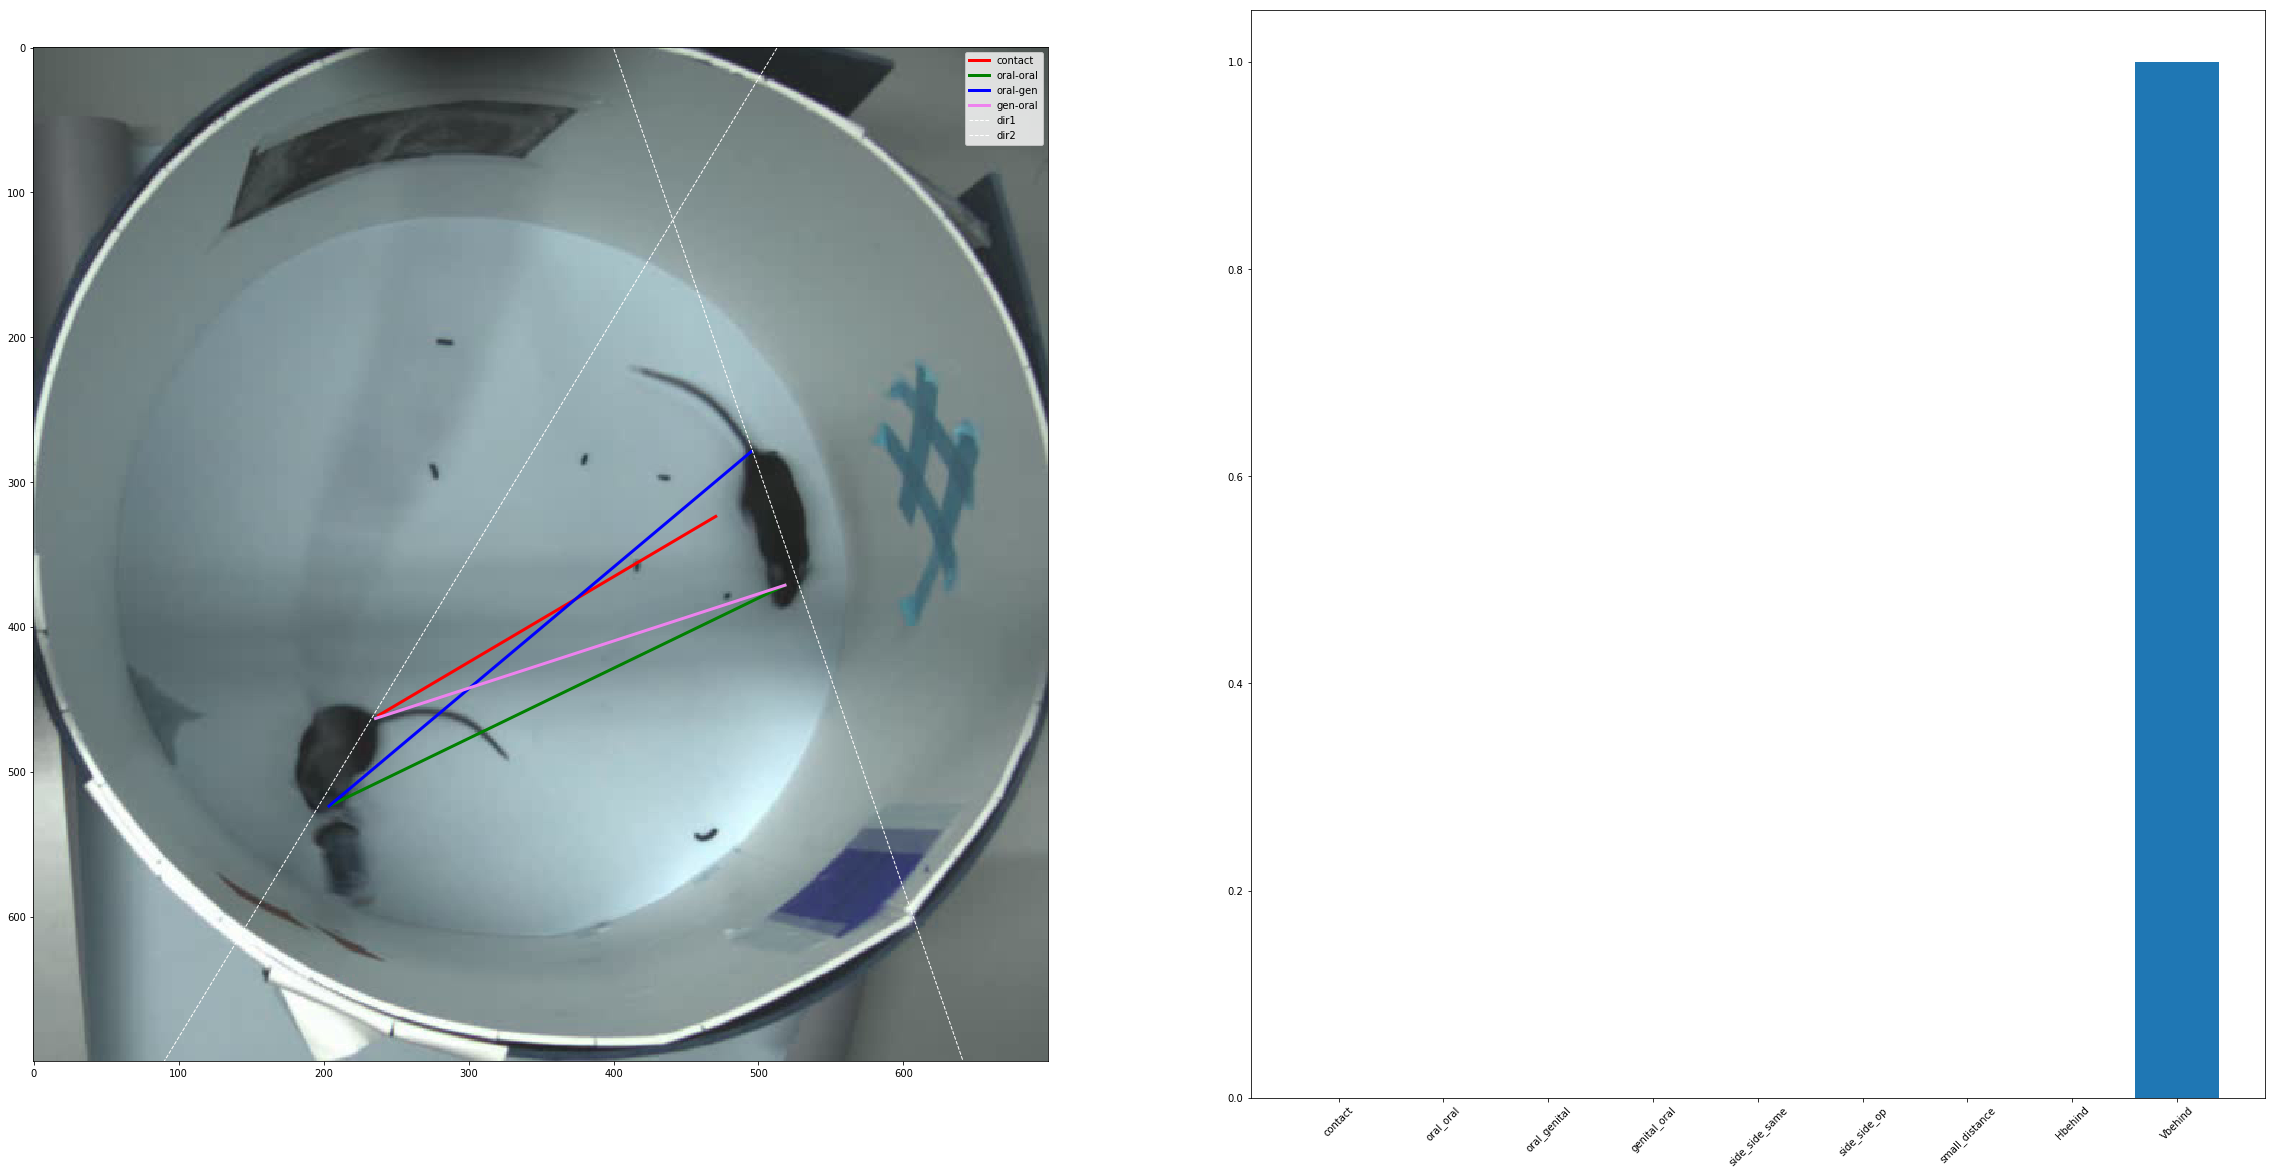

In [33]:
##Create cockriaches video with mice and model on top
create_cockroaches_video(input_video_name, output_video,model1,model2)
## plot some frames and model based distances
frame_n = 300
plot_labeled_frame(input_video_name, frame_n, model1,model2)

## Define ethogram

In [38]:
### compute parameters for static and dynamic ethogram definitions
static_parameters = [get_model_static_parameters(shape_model1 = model1.shape_model[frame_n], shape_model2= model2.shape_model[frame_n]) for frame_n in range(NTIME)]
dynamic_parameters = get_model_dynamic_parameters(model1 = model1, model2= model2, static_parameters = static_parameters)

In [39]:
static_parameters_bias = [get_model_static_parameters(shape_model1 = model1_bias.shape_model[frame_n], shape_model2= model2_bias.shape_model[frame_n]) for frame_n in range(NTIME)]
dynamic_parameters = get_model_dynamic_parameters(model1 = model1_bias, model2= model2_bias, static_parameters = static_parameters_bias)

Text(0.5, 0.98, 'Transition Ethogram')

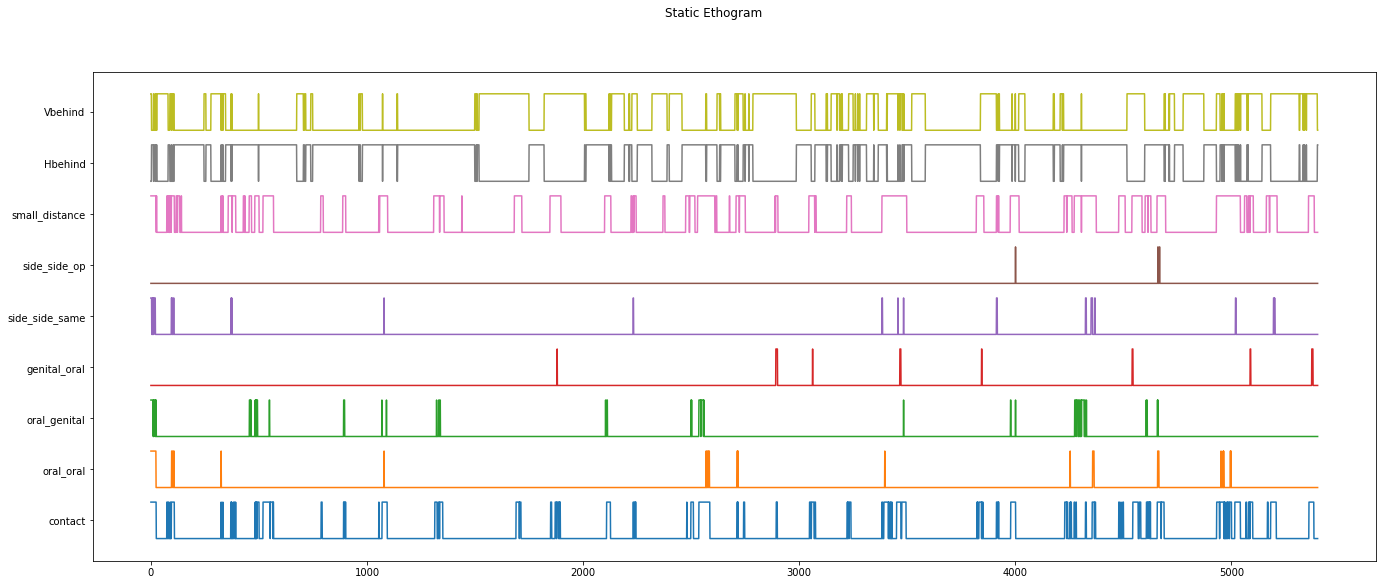

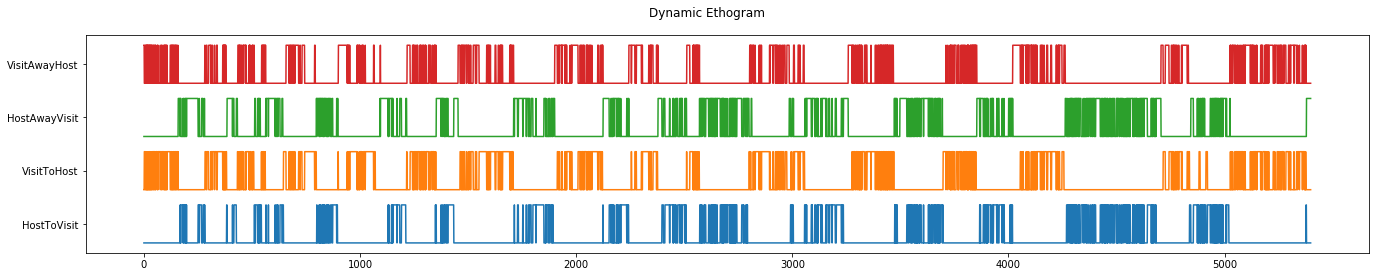

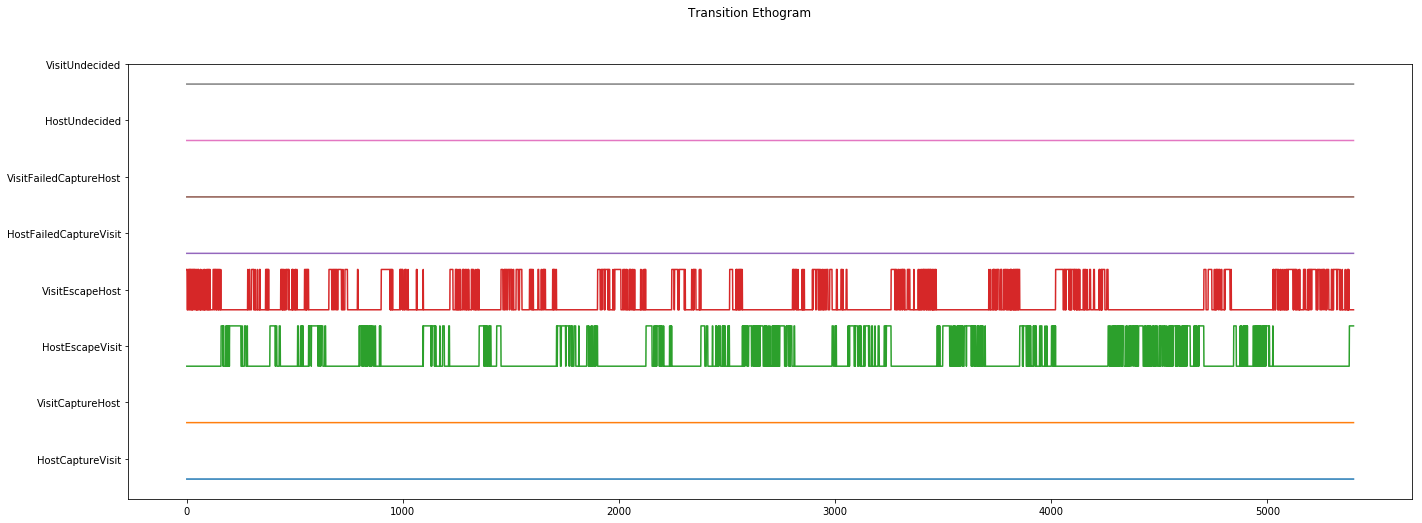

In [42]:
## plot ethogram unbiased version

# define static, dynamic and transitions ethogram
static_ethogram_vector = [static_ethogram(static_parameters[frame_n]) for frame_n in range(NTIME)]
interactions_static = np.array([np.array(list(static_ethogram(static_parameters[frame_n]).values())) for frame_n in range(NTIME)])

fig, ax = plt.subplots(figsize=(23, 9))
tickpos = [1.4*a for a in range(interactions_static.shape[1])]
ax.plot(interactions_static + tickpos);
ax.set_yticks(np.array(tickpos)+ 0.5)
ax.set_yticklabels(fields_static);
fig.suptitle('Static Ethogram')

dynamic_ethogram_vector = dynamic_ethogram(static_ethogram, dynamic_parameters)
interactions_dynamic = np.array([list(dynamic_ethogram_vector.values())[i] for i in range(4)])

fig, ax = plt.subplots(figsize=(23, 4))
tickpos = [1.4*a for a in range(interactions_dynamic.shape[0])]
ax.plot(interactions_dynamic.T + tickpos);
ax.set_yticks(np.array(tickpos)+ 0.5)
ax.set_yticklabels(fields_dyn);
fig.suptitle('Dynamic Ethogram')


transition_ethogram_vector = transition_ethogram(static_ethogram_vector, dynamic_ethogram_vector)
interaction_transitive = np.array([list(transition_ethogram_vector.values())[i] for i in range(8)])

fig, ax = plt.subplots(figsize=(23, 8))
tickpos = [1.4*a for a in range(interaction_transitive.shape[0])]
ax.plot(interaction_transitive.T + tickpos);
ax.set_yticks(np.array(tickpos)+ 0.5)
ax.set_yticklabels(fields_trans);
fig.suptitle('Transition Ethogram')

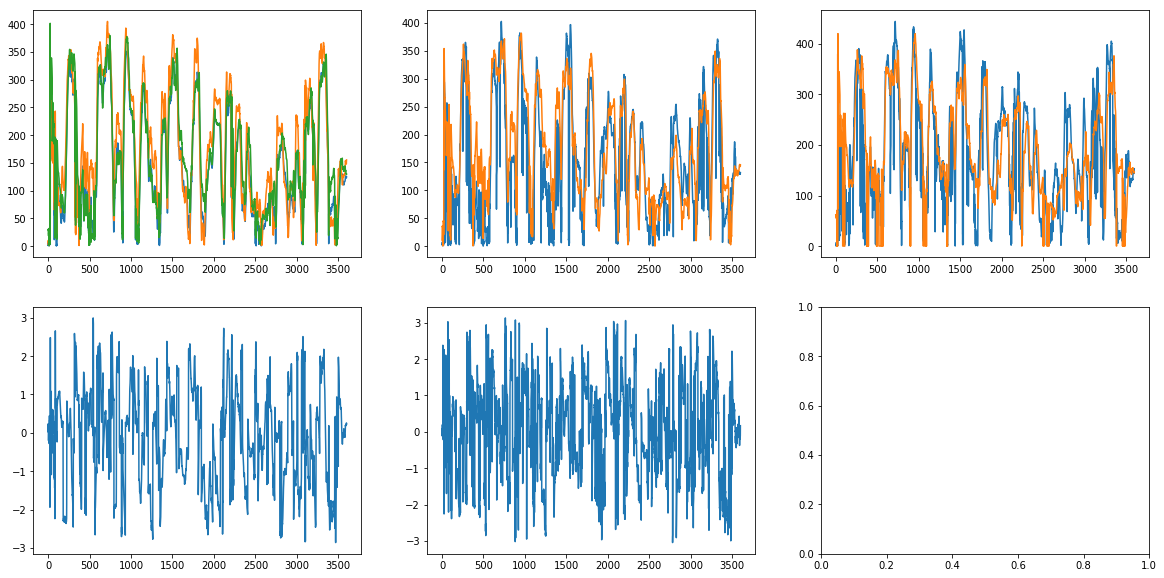

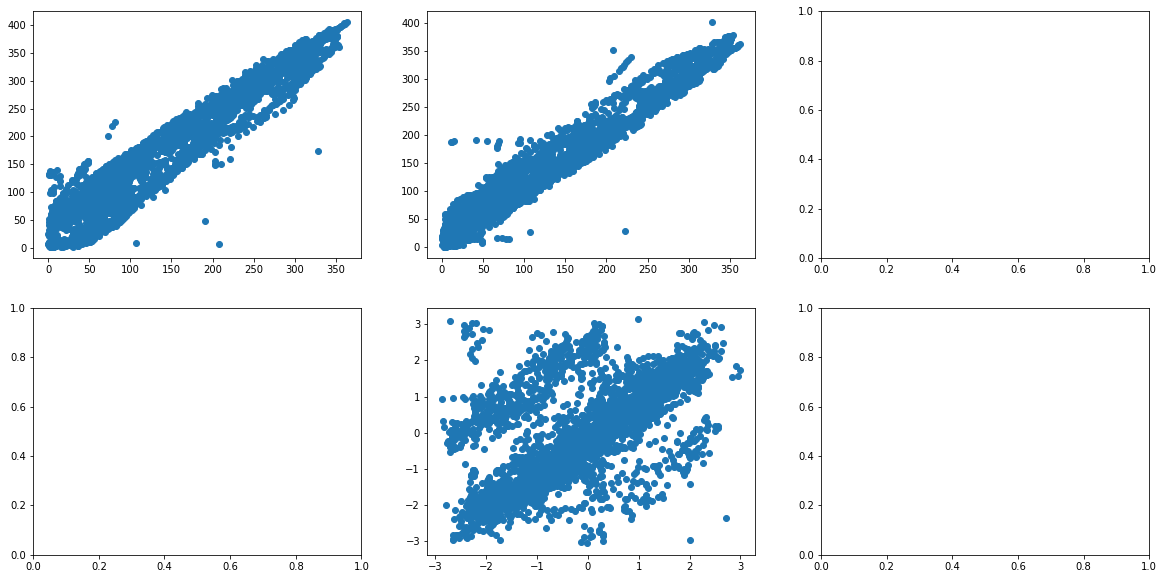

In [704]:
## ploiting parameters evolution

## define parameters 

### all relelevant distances
b1b2 = [parameters[i].distance_parameters.b1b2 for i in range(3600)]
b1h2 = [parameters[i].distance_parameters.b1h2 for i in range(3600)]
b1t2 = [parameters[i].distance_parameters.b1t2 for i in range(3600)]
b2h1 = [parameters[i].distance_parameters.b2h1 for i in range(3600)]
b2t1 = [parameters[i].distance_parameters.b2t1 for i in range(3600)]
h1h2 = [parameters[i].distance_parameters.h1h2 for i in range(3600)]
t1t2 = [parameters[i].distance_parameters.t1t2 for i in range(3600)]

c_b1b2 = [parameters[i].distance_parameters.c_b1b2 for i in range(3600)]
c_h1h2 = [parameters[i].distance_parameters.c_h1h2 for i in range(3600)]
c_b1t2 = [parameters[i].distance_parameters.c_b1t2 for i in range(3600)]
c_b2t1 = [parameters[i].distance_parameters.c_b2t1 for i in range(3600)]
c_h1t2 = [parameters[i].distance_parameters.c_h1t2 for i in range(3600)]
c_h2t1 = [parameters[i].distance_parameters.c_h2t1 for i in range(3600)]


ab1b2 = [parameters[i].direction_parameters.b1b2 for i in range(3600)]
ab1h2 = [parameters[i].direction_parameters.b1h2 for i in range(3600)]
ab2h1 = [parameters[i].direction_parameters.b2h1 for i in range(3600)]
ah1h2 = [parameters[i].direction_parameters.h1h2 for i in range(3600)]

figure, axes = plt.subplots(2,3,figsize = (20,10))

axes[0,0].plot(b1b2)
axes[0,0].plot(b1h2)
axes[0,0].plot(b1t2)

axes[0,1].plot(b2h1)
axes[0,1].plot(b2t1)

axes[0,2].plot(h1h2)
axes[0,2].plot(t1t2)

axes[1,0].plot(ab1b2)
axes[1,1].plot(ah1h2)

figure2, axes2 = plt.subplots(2,3,figsize = (20,10))
axes2[0,0].scatter(b1b2,b1h2)
axes2[0,1].scatter(b1b2,b1t2)

axes2[1,1].scatter(ab1b2,ah1h2)

In [41]:
# ## Solve the intersection problem using elipse formulas, lagrange multipliers and symbolic python

# x1, x2, y1, y2, l1, l2 = symbols('x1 x2 y1 y2 l1 l2')
# frame_n = 100

# a1 = model1.body[frame_n].axis2**2
# b1 = model1.body[frame_n].axis1**2
# c1 = 0
# d1 = -2*model1.body[0].axis2**2*model1.body[frame_n].center[0]
# e1 = -2*model1.body[0].axis2**2*model1.body[frame_n].center[1]
# f1 = a1* model1.body[frame_n].center[0]**2 + b1 * model1.body[frame_n].center[1]**2 - a1*b1


# a2 = model2.body[frame_n].axis2**2
# b2 = model2.body[frame_n].axis1**2
# c2 = 0
# d2 = -2*model2.body[0].axis2**2*model2.body[frame_n].center[0]
# e2 = -2*model2.body[0].axis2**2*model2.body[frame_n].center[1]
# f2 = a1* model2.body[frame_n].center[0]**2 + b1 * model2.body[frame_n].center[1]**2 - a1*b1

# solve([Eq(2*(x1-x2) + l1 *(2*a1*x1 + c1*y1 + d1),0),
#    Eq(2*(y1-y2) + l1 *(2*b1*y1 + d1*x1 + e1), 0),
#    Eq(2*(x2-x1) + l2 *(2*a2*x2 + c2*y2 + d2),0),
#    Eq(2*(y2-y2) + l2 *(2*b2*y2 + d2*x2 + e2), 0),
#    Eq(a1*x1**2+b1*y1**2+d1*x1+e1*y1+f1,0),
#    Eq(a2*x2**2+b2*y2**2+d2*x2+e2*y2+f2,0)], [x1,x2,y1,y2,l1,l2], simplify=False)